### Imports

In [1]:
import pickle as pkl
import pandas as pd
import pandas
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize 
import gensim 
from gensim.models import Word2Vec 
import rouge
from nltk.tokenize.treebank import TreebankWordDetokenizer

import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Activation, Bidirectional, Dropout, Input, concatenate, Reshape, TimeDistributed, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt

### Loading Data

In [2]:
data = pd.read_pickle('data/tokenized.pkl')
eval_df = pd.read_pickle('data/evaluation.pkl')
data

,Unnamed: 0,publication,content
0,0,New York Times,"[washington, —, congressional, republicans, ha..."
1,1,New York Times,"[after, the, bullet, shells, get, the, south, ..."
2,2,New York Times,"[when, walt, disney, ’, s, but, what, they, di..."
3,3,New York Times,"[death, may, be, the, great, equalizer, ,, but..."
4,4,New York Times,"[seoul, ,, south, korea, —, although, north, k..."
...,...,...,...
47220,47220,BBC_tech,"[bt, is, introducing, two, initiatives, from, ..."
47221,47221,BBC_tech,"[computer, users, across, the, world, more, th..."
47222,47222,BBC_tech,"[a, new, european, directive, could, if, it, g..."
47223,47223,BBC_tech,"[the, man, making, sure, us, amit, yoran, was,..."


In [3]:
all_sentences = list(data['content'])
all_sentences.extend(list(eval_df['content']))

### Getting Relevant publications

In [4]:
selected_publications = [
 'Breitbart',
 'CNN',
 'New York Times',
 'NPR',
 'Fox News',
 'Reuters']
# selected_publications = [
#  'Breitbart',
#  'CNN',
#  'New York Times']

In [5]:
all_publications = list(set(data['publication']))
all_publications

['Fox News',
 'Vox',
 'New York Post',
 'Washington Post',
 'Atlantic',
 'CNN',
 'Reuters',
 'BBC_business',
 'NPR',
 'BBC_entertainment',
 'BBC_sport',
 'New York Times',
 'Breitbart',
 'National Review',
 'Guardian',
 'Talking Points Memo',
 'Buzzfeed News',
 'BBC_politics',
 'Business Insider',
 'BBC_tech']

In [6]:
# Take only the contents from publications with >= 3000 samples.
publications = [pub for pub in selected_publications if pub in all_publications and len(data[data['publication'] == pub]) >= 3000]
publications

['Breitbart', 'CNN', 'New York Times', 'NPR', 'Fox News', 'Reuters']

In [7]:
contents = []
for pub in publications:
    contents.append(np.asarray(data[data['publication'] == pub]['content']))

### Padding with special Character

In [8]:
max_seq_length = max([len(seq) for content in contents for seq in content])
max_seq_length

50

In [9]:
end_token = '~?@_'

In [10]:
for content in contents:
    for seq in content:
        seq.extend([end_token] * (max_seq_length - len(seq)))

In [11]:
max_seq_length = max([len(seq) for content in contents for seq in content])
max_seq_length

50

### Vectorize Words

In [12]:
word_dim = 100

In [13]:

word2vec = gensim.models.Word2Vec(all_sentences, min_count = 1,  
                              size = word_dim, window = 5) 

In [14]:
print("Cosine similarity between 'congress' " + 
               "and 'senate' - CBOW : ", 
    word2vec.wv.similarity('congress', 'senate')) 
      
print("Cosine similarity between 'congress' " +
                 "and 'house' - CBOW : ", 
    word2vec.wv.similarity('congress', 'house')) 

Cosine similarity between 'congress' and 'senate' - CBOW :  0.7775129
Cosine similarity between 'congress' and 'house' - CBOW :  0.6631411


In [15]:
word2vec.wv['congressional']

array([-1.1962988 , -0.46952644, -0.2092552 , -0.49508286, -0.5939399 ,
       -0.47643507,  0.51894176,  0.66921806, -0.37765333,  0.97603136,
       -0.25187528, -0.54965436,  0.04709318,  0.04881685,  1.5215728 ,
       -0.5585489 , -0.7406289 , -0.31593478,  0.01350005, -0.73364276,
        0.10632871,  1.1706322 ,  1.117302  , -1.0306296 ,  0.05779231,
       -0.955665  , -0.6990506 , -0.17872794, -0.01317215,  0.6055097 ,
       -1.050981  ,  0.16859053, -1.0042888 ,  0.5624408 , -0.00464836,
       -0.31103954,  0.42768326,  0.28345698,  0.0049701 ,  0.81556165,
       -0.0362828 , -0.3892735 ,  0.32076988, -0.5817319 ,  0.04881718,
        1.3403689 ,  1.0271187 , -0.4893828 , -0.48177782,  0.21739082,
       -1.606795  ,  0.03486909, -0.48941553,  0.05397522, -0.4742551 ,
        0.9308844 , -1.7061324 ,  0.28243405,  0.03195487,  0.8863937 ,
       -1.13895   , -0.46411234,  0.01107024,  0.631226  , -0.38472888,
       -0.2697906 , -1.0853992 ,  0.3250551 , -0.51598775,  0.34

In [16]:
word2vec.wv.similar_by_vector(word2vec.wv['congressional'])

[('congressional', 1.0),
 ('senate', 0.8732990026473999),
 ('judiciary', 0.8281186819076538),
 ('lawmakers', 0.8277795910835266),
 ('gop', 0.823604941368103),
 ('budget', 0.814470648765564),
 ('committee', 0.8116059303283691),
 ('democratic', 0.7952852845191956),
 ('republican', 0.7924261093139648),
 ('conservative', 0.7895176410675049)]

In [17]:
contents = np.asarray(contents)

In [18]:
samples = np.zeros(shape=(contents.shape[0], contents.shape[1], max_seq_length, word_dim))

In [19]:
for i in range(contents.shape[0]):
    for j in range(contents.shape[1]):
        for k in range(max_seq_length):
            samples[i, j, k, :] = word2vec.wv[contents[i, j][k]]

## Funciton Definitions

In [20]:
def squareError(xTrue, xPred):
    return K.square(xTrue - xPred)


In [21]:
def reconstructionLoss(sample, encoder, decoder, f_w, weight): # (L_1 from the paper)
    return K.mean(squareError(sample, decoder(encoder(sample)))) + K.mean(weight*K.log(tf.clip_by_value(f_w(encoder(sample)),1e-10,1.0)))


In [22]:
def divergenceLoss(f_w, encoder, sample, z_j, n_j): # Mean of log f_w(E_theta_i(x_j)) + log (1-f_w(z_j, n_j)) from the paper (L_2).
    return K.mean(K.log(tf.clip_by_value(f_w(encoder(sample)),1e-10,1.0))) + K.mean(K.log(tf.clip_by_value(1 - f_w([z_j, n_j]),1e-10,1.0)))


In [23]:
def sample(data, domain, num_samples):
    N = data.shape[1]
    return tf.convert_to_tensor(data[domain, np.random.choice(N, num_samples, replace=True),:,:], dtype=tf.float32)


In [24]:
# Currently just doing a restriction to the last z variables, might want to do a matrix multiplication?
# pi_Z from the paper. projects a latent distribution in (z, n) to z
def projectZ(encoded):
    return encoded[0] # take zs.

In [25]:
def projectN(encoded):
    return encoded[1] # taek Ns.

In [26]:
# takes in two inputs, n and z, and outputs samples.
def createDecoder(z_dims, n_dims, time_steps, output_dims, lstm_dims):
    # TODO MAYBE: Add in more regularization or different than dropout?

    z_inputs = Input(shape=(z_dims,))
    n_inputs = Input(shape=(n_dims,))
    inputs = concatenate([z_inputs, n_inputs])
    dense = Dropout(0.2)(inputs)
#     # 150 is arbitrary rn...
#     dense = Dense(150)(inputs)
    dense = Dense(time_steps*output_dims)(dense)
    dense = Dropout(0.5)(dense)
    reshape = Reshape((time_steps, output_dims))(dense)
    # TODO Reshape to enforce time_steps?
    bilstm = Bidirectional(LSTM(lstm_dims, activation='tanh', return_sequences=True))(reshape)
    bilstm = Dropout(0.5)(bilstm)
    bilstm = LSTM(lstm_dims, activation='tanh', return_sequences=True)(bilstm)
#     bilstm = Bidirectional(LSTM(lstm_dims, activation='tanh', return_sequences=True))(bilstm)
#     bilstm = Dropout(0.5)(bilstm)
    
    outputs = TimeDistributed(Dense(output_dims, activation='linear'))(bilstm)
#     outputs = TimeDistributed(Dense(output_dims, activation='linear'))(bilstm)
    
    model = Model(inputs=[z_inputs, n_inputs], outputs=outputs)
    
    return model

In [27]:
def createEncoder(time_steps, input_num, z_dims, n_dims, lstm_dims):
    # TODO MAYBE: Add in more regularization or different than dropout?
    inputs = Input(shape=(time_steps, input_num,))
    bilstm = TimeDistributed(Dropout(0.2))(inputs)
#     bilstm = Bidirectional(LSTM(lstm_dims, activation='tanh', return_sequences=True))(bilstm)
#     bilstm = Dropout(0.5)(bilstm)
    dense = Bidirectional(LSTM(lstm_dims, activation='tanh', return_sequences=False))(bilstm)
    dense = Dropout(0.5)(dense)
    z_output = Dense(z_dims, activation='linear')(dense)
    n_output = Dense(n_dims, activation='linear')(dense)
    
    model = Model(inputs=inputs, outputs=[z_output, n_output])
    
    return model

In [28]:
def createDiscriminator(z_dims, n_dims):
    z_inputs = Input(shape=(z_dims,))
    n_inputs = Input(shape=(n_dims,))
    inputs = concatenate([z_inputs, n_inputs])
    
    dense = Dropout(0.2)(inputs)
    # 150, 100 is arbitrary rn...
    dense = Dense(150, activation='relu')(dense)
    dense = Dropout(0.5)(dense)
    dense = Dense(100, activation='relu')(dense)
    dense = Dropout(0.5)(dense)
    output = Dense(1, activation='sigmoid')(dense)
    
    model = Model(inputs=[z_inputs, n_inputs], outputs=output)
    
    return model

In [29]:
def plotLosses(domain, recLosses, divLosses):
    
    plt.figure(figsize=(16, 6))
    plt.rcParams.update({'font.size': 22})
    plt.title('Loss for Training Domain {} Autoencoder'.format(domain))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(range(len(recLosses)), recLosses, range(len(divLosses)), divLosses)
    plt.legend(['Reconstruction', 'Divergence'])
    plt.show()

### When $P_Z$ is known... 

In [30]:

# k is num of domains.
# encoders is a list of encoders.
# decoders is list of decoders.
# samples is a K x N x Timesteps x dim, array of samples, where the 0th index is the domain,
# the 1th index is the # of the sample in that domain, 2th index is the # timesteps per sequence, 3th index is the #
# of dimensions at each timestep
# original_domains is a list of the original domains P_z was derived from.

# Currently assuming P_Z is known. Must approximate P_Z first.
def trainAutoencodersWithPz(samples, encoders, decoders, discriminator, num_samples, original_domains, epochs=10, weight=1.0, lr = 3e-3):
    N = samples.shape[1]
    k = samples.shape[0]
        
    
    for i in range(k):
        if i not in original_domains:
            enc_optimizer = tf.keras.optimizers.Adam(lr)
            dec_optimizer = tf.keras.optimizers.Adam(lr)
            disc_optimizer = tf.keras.optimizers.Adam(lr)
            original_domain = np.random.choice(original_domains)
            encoder = encoders[i]
            decoder = decoders[i]
            original_encoder = encoders[original_domain]
            recLosses = []
            divLosses = []
            epoch = 0
            while(epoch < epochs): # could also do until some convergence criteria.
                p_Xi_samples = sample(samples, i, num_samples)
                p_Z_samples = projectZ(original_encoder(sample(samples, original_domain, num_samples)))
                p_Ni_samples = projectN(encoder(sample(samples, i, num_samples)))

                with tf.GradientTape() as enc_tape, tf.GradientTape() as dec_tape, tf.GradientTape() as disc_tape:

                    reconstruction_loss = reconstructionLoss(p_Xi_samples, encoder, decoder, discriminator, weight)

                    # negative b/c gradient ascent.
                    divergence_loss = -1 * divergenceLoss(discriminator, encoder, p_Xi_samples, p_Z_samples, p_Ni_samples)

                gradients_of_encoder = enc_tape.gradient(reconstruction_loss, encoder.trainable_variables)
                gradients_of_decoder = dec_tape.gradient(reconstruction_loss, decoder.trainable_variables)
                gradients_of_discriminator = disc_tape.gradient(divergence_loss, discriminator.trainable_variables)
                
                enc_optimizer.apply_gradients(zip(gradients_of_encoder, encoder.trainable_variables))
                dec_optimizer.apply_gradients(zip(gradients_of_decoder, decoder.trainable_variables))
                disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
                
                recLosses.append(reconstruction_loss)
                divLosses.append(divergence_loss)
                print('Domain {}, Epoch {}:\n\tReconstruction Loss: {}\n\tDivergence Loss: {}'.format(i, epoch+1, reconstruction_loss, divergence_loss))
                
                epoch+=1
            plotLosses(i, recLosses, divLosses)
            

### When $P_Z$ is unknown...
"A straight-forward approach for learning the latent distribution PZ is to train a regularized autoencoder on data from a
single representative domain. However, such a representation could potentially capture variability that is specific to
that one domain. To learn a more invariant latent representation, we propose the following extension of our autoencoder
framework. The basic idea is to alternate between training
multiple autoencoders until they agree on a latent representation that is effective for their respective domains. This is
particularly relevant for applications to biology; for example, often one is interested in learning a latent representation
that integrates all of the data modalities."

In [31]:

# k is num of domains.
# encoders is a list of encoders.
# decoders is list of decoders.
# samples is a K x N x Timesteps x dim, array of samples, where the 0th index is the domain,
# the 1th index is the # of the sample in that domain, 2th index is the # timesteps per sequence, 3th index is the #
# of dimensions at each timestep
# domains is a list of the domains we are currently training over.

def trainAutoencodersInitial(samples, encoders, decoders, discriminator, num_samples, domains, epochs=10, weight=1.0, lr = 3e-3):
    N = samples.shape[1]
    k = samples.shape[0]
    
    for i in domains:
        encoder = encoders[i]
        decoder = decoders[i]
        enc_optimizer = tf.keras.optimizers.Adam(lr)
        dec_optimizer = tf.keras.optimizers.Adam(lr)
        disc_optimizer = tf.keras.optimizers.Adam(lr)
        for j in domains:
            if i != j:
                j_encoder = encoders[j]
                recLosses = []
                divLosses = []
                epoch = 0
                while(epoch < epochs): # could also do until some convergence criteria.
                    p_Xi_samples = sample(samples, i, num_samples)
                    p_Zj_samples = projectZ(j_encoder(sample(samples, j, num_samples)))
                    p_Ni_samples = projectN(encoder(sample(samples, i, num_samples)))

                    with tf.GradientTape() as enc_tape, tf.GradientTape() as dec_tape, tf.GradientTape() as disc_tape:

                        reconstruction_loss = reconstructionLoss(p_Xi_samples, encoder, decoder, discriminator, weight)
                        #print(p_Xi_samples)

                        # negative b/c gradient ascent.
                        divergence_loss = -1 * divergenceLoss(discriminator, encoder, p_Xi_samples, p_Zj_samples, p_Ni_samples)
                        
                    gradients_of_encoder = enc_tape.gradient(reconstruction_loss, encoder.trainable_variables)
                    gradients_of_decoder = dec_tape.gradient(reconstruction_loss, decoder.trainable_variables)
                    gradients_of_discriminator = disc_tape.gradient(divergence_loss, discriminator.trainable_variables)
            

                    enc_optimizer.apply_gradients(zip(gradients_of_encoder, encoder.trainable_variables))
                    dec_optimizer.apply_gradients(zip(gradients_of_decoder, decoder.trainable_variables))
                    disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
                
                    recLosses.append(reconstruction_loss)
                    divLosses.append(divergence_loss)
                    
                    print('Domain {}, Epoch {}:\n\tReconstruction Loss: {}\n\tDivergence Loss: {}'.format(i, epoch+1, reconstruction_loss, divergence_loss))
                    epoch+=1
                plotLosses(i, recLosses, divLosses)
            

In [32]:
# samples is a K x N x Timesteps x dim, array of samples, where the 0th index is the domain,
# the 1th index is the # of the sample in that domain, 2th index is the # timesteps per sequence, 3th index is the #
# of dimensions at each timestep

def initModel(samples, z_dims, n_dims, lstm_dims):
    
    k = samples.shape[0]
    N = samples.shape[1]
    time_steps = samples.shape[2]
    dim = samples.shape[3]
    
    
    
    discriminator = createDiscriminator(z_dims, n_dims)
    
    encoders = []
    decoders = []
    
    for i in range(k):
        encoders.append(createEncoder(time_steps, dim, z_dims, n_dims, lstm_dims))
        decoders.append(createDecoder(z_dims, n_dims, time_steps, dim, lstm_dims))
    
    return encoders, decoders, discriminator

In [33]:
def translate(start_sequences, samples, encoders, decoders, start_domain, end_domain):
    N = samples.shape[1]
    print(start_sequences.shape)
    num_samples = start_sequences.shape[0]
    
    start_encoder = encoders[start_domain]
    end_encoder = encoders[end_domain]
    end_decoder = decoders[end_domain]
    
    z = projectZ(start_encoder(start_sequences))
    n = projectN(end_encoder(sample(samples, end_domain, num_samples)))
    
    end_sequences = end_decoder([z, n])
    return end_sequences
    

In [34]:
def vecSeqToSentence(sequence):
    sequence = K.eval(sequence)
    sentence = []
    for i in range(sequence.shape[0]):
        word = sequence[i,:]
        #print(word)
        #print(word2vec.wv.similar_by_vector(word))
        sentence.append(word2vec.wv.similar_by_vector(word)[0][0])
    return sentence
    print(sentence)

In [35]:
n_dims = 100 # len(n)
z_dims = 100 # len(Z)

lstm_dims = 64

num_epochs = 25
num_samples = 128

weight = 1

lr = 3e-3

original_domains = [0, 1]
# Marcus: Fox & Breitbart [4, 0]
# LK: Reuters & NPR [5, 3]
# Sophie: CNN & NYT [1, 2]
# Connor: CNN & Fox News [1, 4]


# selected_publications = [
#  'Breitbart',
#  'CNN',
#  'New York Times',
#  'NPR',
#  'Fox News',
#  'Reuters']


In [36]:
encoders, decoders, discriminator = initModel(samples, z_dims, n_dims, lstm_dims)

### Original First Sentence from 0

In [37]:
' '.join(contents[0, 0])

'on tuesday ’ s broadcast ” zeleny said , “ and she ’ s having a difficult time in federal prison , no question . ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_'

In [38]:
seq = tf.convert_to_tensor(np.asarray([samples[0, 0, :, :]]), dtype=tf.float32)
translation = translate(seq, samples, encoders, decoders, original_domains[0], original_domains[1])

(1, 50, 100)


### Original First Sentence from 0 translated to 1 before Training (Random)

In [39]:

vecSeqToSentence(translation[0,:,:])


['needham',
 'aghast',
 'nyp',
 'difference.',
 'mazur',
 'mazur',
 'domes',
 'domes',
 'irreparable',
 'denouement',
 'denouement',
 'subjugation',
 'subjugation',
 'revealed.',
 'nanticoke',
 'nanticoke',
 'lapine',
 'lapine',
 'lapine',
 'boubaker',
 'boubaker',
 'boubaker',
 'boubaker',
 'tracie',
 'tracie',
 'golan',
 'indystar',
 'gripe',
 'avalon',
 'avalon',
 'avalon',
 'bentonville',
 'opb',
 'opb',
 'mouths',
 'hallock',
 'cruickshank',
 'cruickshank',
 'repetitive',
 'cruickshank',
 'shakedowns',
 'expat',
 'nautilus',
 'nautilus',
 'nautilus',
 'nautilus',
 'nautilus',
 'nautilus',
 'finley',
 'bulldog']

Domain 0, Epoch 1:
	Reconstruction Loss: 0.23489445447921753
	Divergence Loss: 1.4144666194915771
Domain 0, Epoch 2:
	Reconstruction Loss: -0.0847773551940918
	Divergence Loss: 1.3222932815551758
Domain 0, Epoch 3:
	Reconstruction Loss: -0.20793163776397705
	Divergence Loss: 1.2671427726745605
Domain 0, Epoch 4:
	Reconstruction Loss: -0.2152145504951477
	Divergence Loss: 1.130013108253479
Domain 0, Epoch 5:
	Reconstruction Loss: -0.11253911256790161
	Divergence Loss: 0.9675825834274292
Domain 0, Epoch 6:
	Reconstruction Loss: 0.07693153619766235
	Divergence Loss: 0.8116381764411926
Domain 0, Epoch 7:
	Reconstruction Loss: 0.157678484916687
	Divergence Loss: 0.7116734981536865
Domain 0, Epoch 8:
	Reconstruction Loss: 0.28145909309387207
	Divergence Loss: 0.702094554901123
Domain 0, Epoch 9:
	Reconstruction Loss: 0.27154093980789185
	Divergence Loss: 0.737032413482666
Domain 0, Epoch 10:
	Reconstruction Loss: 0.07068204879760742
	Divergence Loss: 0.8827105760574341
Domain 0, Epoch 11:
	R

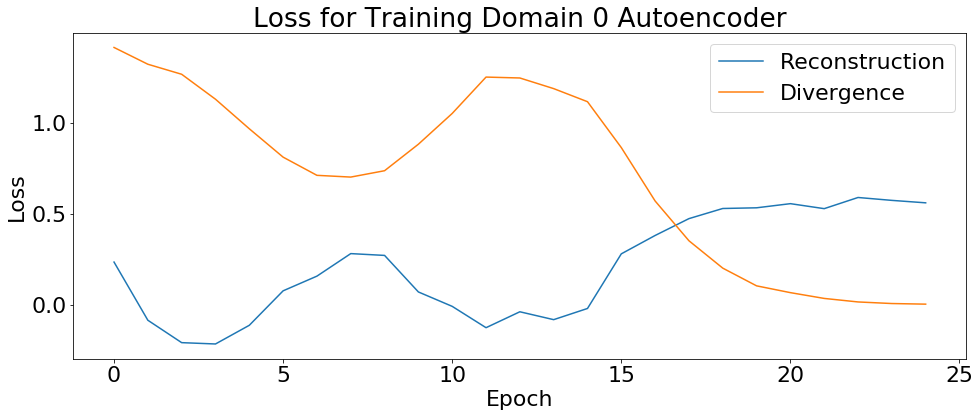

Domain 1, Epoch 1:
	Reconstruction Loss: 0.821138858795166
	Divergence Loss: 19.455934524536133
Domain 1, Epoch 2:
	Reconstruction Loss: -0.4248841404914856
	Divergence Loss: 10.005880355834961
Domain 1, Epoch 3:
	Reconstruction Loss: -2.322669744491577
	Divergence Loss: 4.646157741546631
Domain 1, Epoch 4:
	Reconstruction Loss: -4.490087032318115
	Divergence Loss: 5.263302803039551
Domain 1, Epoch 5:
	Reconstruction Loss: -6.402722358703613
	Divergence Loss: 7.121421813964844
Domain 1, Epoch 6:
	Reconstruction Loss: -7.494524955749512
	Divergence Loss: 8.194828987121582
Domain 1, Epoch 7:
	Reconstruction Loss: -8.044756889343262
	Divergence Loss: 8.717446327209473
Domain 1, Epoch 8:
	Reconstruction Loss: -7.58528470993042
	Divergence Loss: 8.243010520935059
Domain 1, Epoch 9:
	Reconstruction Loss: -6.083847999572754
	Divergence Loss: 6.783500671386719
Domain 1, Epoch 10:
	Reconstruction Loss: -3.820913314819336
	Divergence Loss: 4.468632221221924
Domain 1, Epoch 11:
	Reconstruction Lo

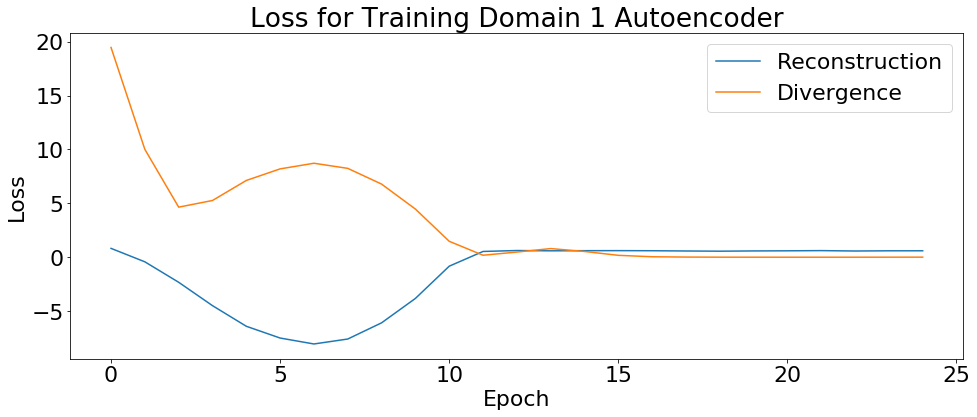

In [40]:
trainAutoencodersInitial(samples, encoders, decoders, discriminator, num_samples, original_domains, epochs=num_epochs, weight=weight, lr = lr)


### Original First Sentence from 0 translated to 1 after training

In [41]:
translation = translate(seq, samples, encoders, decoders, original_domains[0], original_domains[1])
vecSeqToSentence(translation[0,:,:])

(1, 50, 100)


['washington',
 'cnn',
 'cnn',
 'doj',
 'doj',
 'issue',
 'issue',
 'issue',
 'issue',
 'issue',
 'issue',
 'issue',
 'issue',
 'issue',
 'issue',
 'issue',
 'issue',
 'issue',
 'clearly',
 'clearly',
 'clearly',
 'clearly',
 'successful',
 'successful',
 'duty',
 'duty',
 'duty',
 '~?@_',
 '~?@_',
 '~?@_',
 '~?@_',
 '~?@_',
 '~?@_',
 '~?@_',
 '~?@_',
 '~?@_',
 '~?@_',
 '~?@_',
 '~?@_',
 '~?@_',
 '~?@_',
 '~?@_',
 '~?@_',
 '~?@_',
 '~?@_',
 '~?@_',
 '~?@_',
 '~?@_',
 '~?@_',
 '~?@_']

Domain 2, Epoch 1:
	Reconstruction Loss: 0.7568528652191162
	Divergence Loss: 15.241006851196289
Domain 2, Epoch 2:
	Reconstruction Loss: -0.016825735569000244
	Divergence Loss: 5.2126359939575195
Domain 2, Epoch 3:
	Reconstruction Loss: -0.9302558302879333
	Divergence Loss: 1.6482751369476318
Domain 2, Epoch 4:
	Reconstruction Loss: -1.989565134048462
	Divergence Loss: 2.675279140472412
Domain 2, Epoch 5:
	Reconstruction Loss: -3.094478130340576
	Divergence Loss: 3.7431480884552
Domain 2, Epoch 6:
	Reconstruction Loss: -4.239481449127197
	Divergence Loss: 4.825789928436279
Domain 2, Epoch 7:
	Reconstruction Loss: -4.623553276062012
	Divergence Loss: 5.214649200439453
Domain 2, Epoch 8:
	Reconstruction Loss: -4.595030784606934
	Divergence Loss: 5.175758361816406
Domain 2, Epoch 9:
	Reconstruction Loss: -3.979313850402832
	Divergence Loss: 4.594722747802734
Domain 2, Epoch 10:
	Reconstruction Loss: -2.841769218444824
	Divergence Loss: 3.426403284072876
Domain 2, Epoch 11:
	Reconstructio

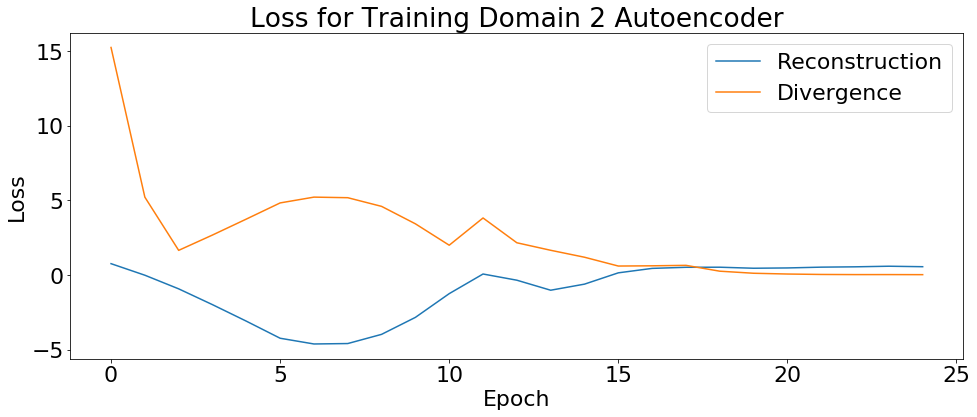

Domain 3, Epoch 1:
	Reconstruction Loss: 0.7610056400299072
	Divergence Loss: 20.02720069885254
Domain 3, Epoch 2:
	Reconstruction Loss: 0.5953942537307739
	Divergence Loss: 9.497657775878906
Domain 3, Epoch 3:
	Reconstruction Loss: 0.2633674740791321
	Divergence Loss: 4.758066177368164
Domain 3, Epoch 4:
	Reconstruction Loss: -0.2975892424583435
	Divergence Loss: 1.6253783702850342
Domain 3, Epoch 5:
	Reconstruction Loss: -1.0659676790237427
	Divergence Loss: 1.705126404762268
Domain 3, Epoch 6:
	Reconstruction Loss: -2.0204782485961914
	Divergence Loss: 2.6064915657043457
Domain 3, Epoch 7:
	Reconstruction Loss: -2.8709981441497803
	Divergence Loss: 3.4329209327697754
Domain 3, Epoch 8:
	Reconstruction Loss: -3.5097451210021973
	Divergence Loss: 4.0454583168029785
Domain 3, Epoch 9:
	Reconstruction Loss: -3.3912136554718018
	Divergence Loss: 3.941016674041748
Domain 3, Epoch 10:
	Reconstruction Loss: -2.6461594104766846
	Divergence Loss: 3.171602725982666
Domain 3, Epoch 11:
	Reconst

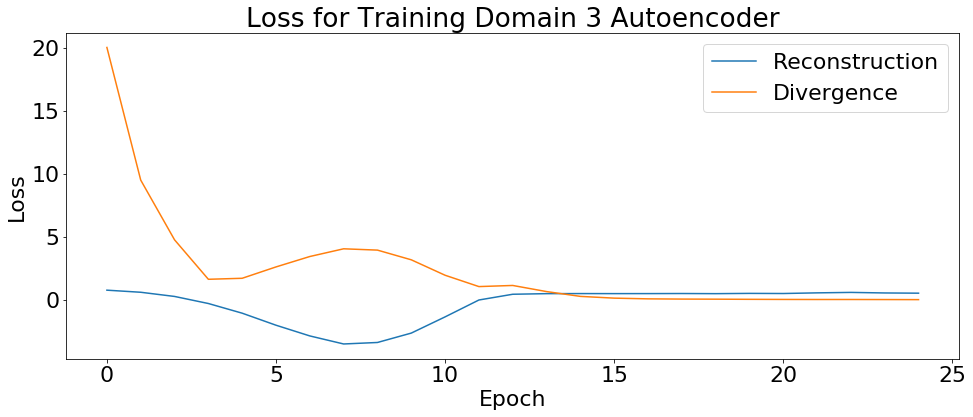

Domain 4, Epoch 1:
	Reconstruction Loss: 0.739963710308075
	Divergence Loss: 5.590182781219482
Domain 4, Epoch 2:
	Reconstruction Loss: 0.6523697972297668
	Divergence Loss: 0.2132924348115921
Domain 4, Epoch 3:
	Reconstruction Loss: 0.20830658078193665
	Divergence Loss: 0.4996757507324219
Domain 4, Epoch 4:
	Reconstruction Loss: -0.49753421545028687
	Divergence Loss: 1.1279189586639404
Domain 4, Epoch 5:
	Reconstruction Loss: -1.1484606266021729
	Divergence Loss: 1.7782752513885498
Domain 4, Epoch 6:
	Reconstruction Loss: -1.777047872543335
	Divergence Loss: 2.364665985107422
Domain 4, Epoch 7:
	Reconstruction Loss: -2.1714212894439697
	Divergence Loss: 2.771063804626465
Domain 4, Epoch 8:
	Reconstruction Loss: -2.5181336402893066
	Divergence Loss: 3.075178861618042
Domain 4, Epoch 9:
	Reconstruction Loss: -2.2594103813171387
	Divergence Loss: 2.8581573963165283
Domain 4, Epoch 10:
	Reconstruction Loss: -1.432797908782959
	Divergence Loss: 2.26532244682312
Domain 4, Epoch 11:
	Reconstr

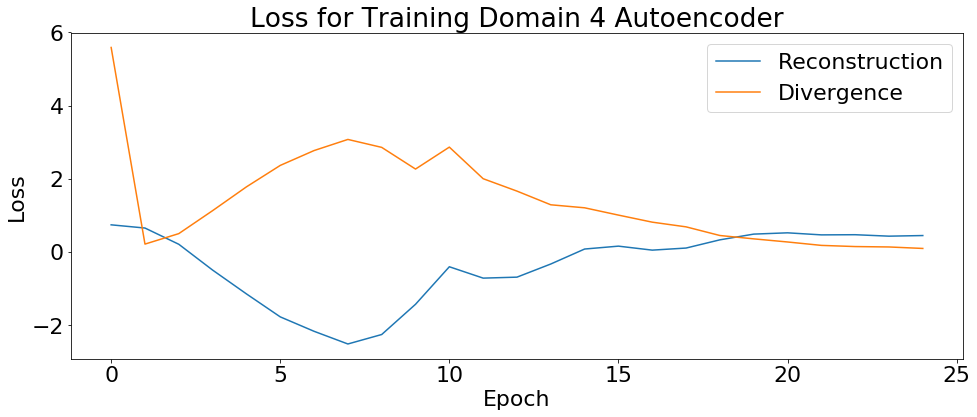

Domain 5, Epoch 1:
	Reconstruction Loss: 0.8506708145141602
	Divergence Loss: 23.026275634765625
Domain 5, Epoch 2:
	Reconstruction Loss: 0.8509060144424438
	Divergence Loss: 23.03009605407715
Domain 5, Epoch 3:
	Reconstruction Loss: 0.7314859628677368
	Divergence Loss: 23.045534133911133
Domain 5, Epoch 4:
	Reconstruction Loss: 0.6409122347831726
	Divergence Loss: 23.08064079284668
Domain 5, Epoch 5:
	Reconstruction Loss: 0.618276059627533
	Divergence Loss: 23.111862182617188
Domain 5, Epoch 6:
	Reconstruction Loss: 0.5895544290542603
	Divergence Loss: 23.12167739868164
Domain 5, Epoch 7:
	Reconstruction Loss: 0.5834795236587524
	Divergence Loss: 23.12062644958496
Domain 5, Epoch 8:
	Reconstruction Loss: 0.5990704298019409
	Divergence Loss: 23.090255737304688
Domain 5, Epoch 9:
	Reconstruction Loss: 0.5776880979537964
	Divergence Loss: 23.06589126586914
Domain 5, Epoch 10:
	Reconstruction Loss: 0.5959779620170593
	Divergence Loss: 23.032482147216797
Domain 5, Epoch 11:
	Reconstruction

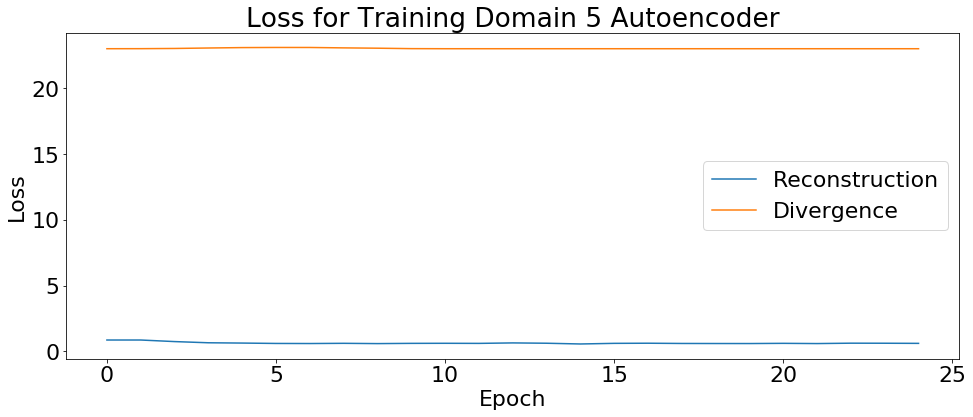

In [42]:
trainAutoencodersWithPz(samples, encoders, decoders, discriminator, num_samples, original_domains, epochs=num_epochs, weight=weight, lr = lr)


### Original First Sentence from 0 translated to 2 after Training

In [43]:
translation = translate(seq, samples, encoders, decoders, 0, 2)
vecSeqToSentence(translation[0,:,:])

(1, 50, 100)


['although',
 'while',
 'although',
 'issue',
 'issue',
 'issue',
 'issue',
 'issue',
 'issue',
 'issue',
 'issue',
 'issue',
 'issue',
 'issue',
 'issue',
 'message',
 'clearly',
 'clearly',
 'answering',
 'answering',
 'answering',
 'trouble',
 'trouble',
 'successful',
 'successful',
 'duty',
 'duty',
 '~?@_',
 '~?@_',
 '~?@_',
 '~?@_',
 '~?@_',
 '~?@_',
 '~?@_',
 '~?@_',
 '~?@_',
 '~?@_',
 '~?@_',
 '~?@_',
 '~?@_',
 '~?@_',
 '~?@_',
 '~?@_',
 '~?@_',
 '~?@_',
 '~?@_',
 '~?@_',
 '~?@_',
 '~?@_',
 '~?@_']

## All Translations

In [ ]:
detok = TreebankWordDetokenizer()
for i in range(len(selected_publications)):
        for j in range(len(selected_publications)):
            if (i != j):
                pub1=publications[i]
                pub2=publications[j]
                
                encoder = encoders[i]
                decoder = decoders[j]
                
                source_article = samples[i][0:1]
                
                translated = decoder(encoder(tf.convert_to_tensor(source_article, dtype=tf.float32)))
                
                print(pub1,"to",pub2)
                print("\t",detok.detokenize(vecSeqToSentence(source_article[0])))
                print("\nto\n")
                print("\t",detok.detokenize(vecSeqToSentence(translated[0])), "\n")
                

Breitbart to CNN
	 on tuesday ’ s broadcast ” zeleny said, “ and she ’ s having a difficult time in federal prison, no question . ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_

to

	 washington washington washington doj although issue issue issue message message issue message message message message message clearly clearly clearly clearly clearly successful disappointing disappointing ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ 

Breitbart to New York Times
	 on tuesday ’ s broadcast ” zeleny said, “ and she ’ s having a difficult time in federal prison, no question . ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_

to

	 although although issue issue issue issue issue issue issue issue issue message issue message clearly clearly critical answering

## Evaluation with Rouge

In [ ]:
eval_df

In [ ]:
contents = []
for pub in publications:
    contents.append(np.asarray(eval_df[eval_df['publication'] == pub]['content']))
    
for content in contents:
    for seq in content:
        seq.extend([end_token] * (max_seq_length - len(seq)))
    
contents = np.asarray(contents)
samples = np.zeros(shape=(contents.shape[0], contents.shape[1], max_seq_length, word_dim))

for i in range(contents.shape[0]):
    for j in range(contents.shape[1]):
        for k in range(max_seq_length):
            samples[i, j, k, :] = word2vec.wv[contents[i, j][k]]

In [ ]:
evaluator = rouge.Rouge(metrics=['rouge-n', 'rouge-l', 'rouge-w'],
                        max_n=4,
                        limit_length=True,
                        length_limit=100,
                        length_limit_type='words',
                        apply_avg=False,
                        apply_best=True,
                        alpha=0.5, # Default F1_score
                        weight_factor=1.2,
                        stemming=True
                       )

In [ ]:
def evaluateOnArticles(articles, encoder, decoder):
    translated = decoder(encoder(tf.convert_to_tensor(articles, dtype=tf.float32)))
       
    original_sentences = [detok.detokenize(vecSeqToSentence(tokens)) for tokens in articles]
    
    translated_sentences = [detok.detokenize(vecSeqToSentence(tokens)) for tokens in translated]
    
    scores = evaluator.get_scores(translated_sentences, original_sentences)
    
    for metric, results in sorted(scores.items(), key=lambda x: x[0]):
        print('\t{}:\t{}: {:5.2f}\t{}: {:5.2f}\t{}: {:5.2f}'.format(metric, 'P', 100.0 * results['p'], 'R', 100.0 * results['r'], 'F1', 100.0 * results['f']))

In [ ]:
def evaluate(articles, encoders, decoders):
    
    for i in range(len(selected_publications)):
        for j in range(len(selected_publications)):
            if (i != j):
                pub1=publications[i]
                pub2=publications[j]
                #source_articles = articles_df.loc[articles_df['publication'] == pub1]['content'].tolist()
                source_articles = articles[i]
                
                print(pub1,"to",pub2)
                evaluateOnArticles(source_articles, encoders[i], decoders[j])
                print()

In [ ]:
evaluate(samples, encoders, decoders)